In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
##Import any other packages you may need here
import matplotlib.gridspec as gridspec
from itertools import chain #Built-in mutable sequence.
import scipy # to run pearson correlation
#sns.set_style('whitegrid')
import matplotlib.image as image
%matplotlib inline

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
#all_xray_df.sample(3)
all_xray_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  
3                        0.171  0.171          NaN  
4                        0.143  0.143          NaN

In [3]:
all_xray_df.shape

(112120, 12)

In [4]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
#sample_df.sample(3)
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   
3                2992                 2991                        0.143   
4                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168  
3                        0.143  
4                        0.168

In [5]:
sample_df.shape

(5606, 11)

**Differences between the Data_Entry_2017.csv and sample_labels.csv:**

sample_labels.csv - will be used for pixel analysis
- Patient Age: has Y, M and D ( Year, Month and days) in the end

Data_Entry_2017.csv - will be used to get familiar with the data
- has extra column at the named named Unnamed Column

**Generate Descriptive statistics to summarize**
- central tendency
- dispersion 
- shape of a datasets distribution, excluding NaN value

In [6]:
all_xray_df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

**Summary of a DataFrame.**

In [7]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [8]:
sample_df.describe()

Follow-up #    Patient ID  OriginalImageWidth  OriginalImageHeight  \
count  5606.000000   5606.000000         5606.000000          5606.000000   
mean      8.616661  14330.617017         2644.795755          2491.087406   
std      15.565815   8411.477789          347.188754           399.119063   
min       0.000000     13.000000         1362.000000           966.000000   
25%       0.000000   7289.000000         2500.000000          2048.000000   
50%       3.000000  13993.000000         2542.000000          2544.000000   
75%      10.000000  20655.500000         2992.000000          2991.000000   
max     177.000000  30797.000000         3266.000000          3056.000000   

       OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
count                  5606.000000                  5606.000000  
mean                      0.155467                     0.155467  
std                       0.016201                     0.016201  
min                       0.115000                     0.115000  
25%                       0.143000                     0.143000  
50%                       0.143000                     0.143000  
75%                       0.168000                     0.168000  
max                       0.198800                     0.198800

In [9]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


Data_Entry_2017.csv is much bigger than sample_labels.csv

## Patient demographic data such as gender, age, patient position,etc.

In [10]:
#generate copy all_xray_df to clean alter and study the data
df = all_xray_df.copy()

## Patient Age

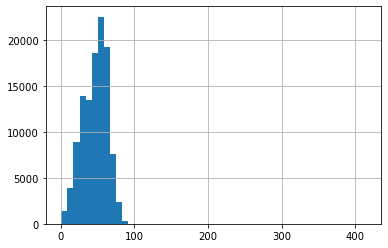

In [11]:
df['Patient Age'].hist(bins = 50)

In [12]:
df[df['Patient Age'] > 100]

Image Index           Finding Labels  Follow-up #  Patient ID  \
20852   00005567_000.png       Effusion|Pneumonia            0        5567   
46965   00011973_002.png                    Edema            2       11973   
48284   00012238_010.png               No Finding           10       12238   
55742   00013950_000.png               No Finding            0       13950   
58650   00014520_026.png        Infiltration|Mass           26       14520   
62929   00015558_000.png               No Finding            0       15558   
74884   00018366_044.png             Pneumothorax           44       18366   
78795   00019346_000.png             Infiltration            0       19346   
84810   00020900_002.png               No Finding            2       20900   
85404   00021047_002.png  Mass|Pleural_Thickening            2       21047   
86264   00021275_003.png               No Finding            3       21275   
91369   00022811_000.png               No Finding            0       22811   
95794   00025206_000.png        Infiltration|Mass            0       25206   
98495   00026028_001.png              Atelectasis            1       26028   
101194  00026871_000.png               No Finding            0       26871   
104590  00027989_000.png               No Finding            0       27989   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
20852           412              M            AP                 3056   
46965           414              M            AP                 3056   
48284           148              M            PA                 2992   
55742           148              M            PA                 2964   
58650           150              M            PA                 2992   
62929           149              M            PA                 2992   
74884           152              F            PA                 2302   
78795           151              F            PA                 2678   
84810           411              M            AP                 3056   
85404           412              M            AP                 3056   
86264           413              F            AP                 3056   
91369           412              M            PA                 3056   
95794           153              M            PA                 2992   
98495           154              M            PA                 2992   
101194          155              F            PA                 2992   
104590          155              M            PA                 2992   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
20852      2544                        0.139  0.139          NaN  
46965      2544                        0.139  0.139          NaN  
48284      2991                        0.143  0.143          NaN  
55742      2939                        0.143  0.143          NaN  
58650      2991                        0.143  0.143          NaN  
62929      2991                        0.143  0.143          NaN  
74884      2991                        0.143  0.143          NaN  
78795      2774                        0.143  0.143          NaN  
84810      2544                        0.139  0.139          NaN  
85404      2544                        0.139  0.139          NaN  
86264      2544                        0.139  0.139          NaN  
91369      2544                        0.139  0.139          NaN  
95794      2991                        0.143  0.143          NaN  
98495      2991                        0.143  0.143          NaN  
101194     2991                        0.143  0.143          NaN  
104590     2991                        0.143  0.143          NaN

The 16 patients above are most likely a mistake since they are over 148 years of age. Hence they will be dropped

In [13]:
df = df[df['Patient Age'] <= 100]

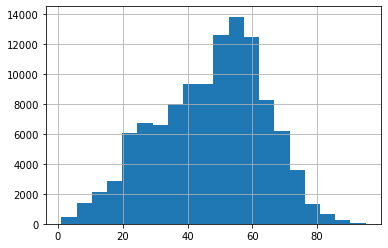

In [14]:
df['Patient Age'].hist(bins = 20)

The above histogram shows us most patients are over between 40 and 60 years of age.

In [15]:
df['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

## Gender

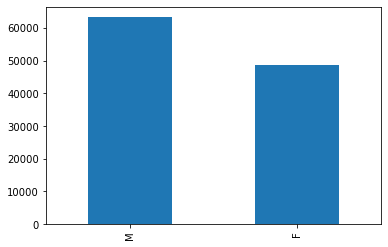

In [16]:
df['Patient Gender'].value_counts().plot(kind = 'bar')

In [17]:
patient_gender_m = df[df['Patient Gender'] == 'M']
patient_gender_f = df[df['Patient Gender'] == 'F']

In [18]:
print(f'Gender distribution\nMale: {len(patient_gender_m)} ({100.0 * len(patient_gender_m)/len(df):.2f}%), Female: {len(patient_gender_f)} ({100.0 *len(patient_gender_f)/len(df):.2f}%)')

Gender distribution
Male: 63328 (56.49%), Female: 48776 (43.51%)


The above bar chart shows the dataset contains more men

## The x-ray views taken (i.e. view position)

In [19]:
df['View Position'].unique()

array(['PA', 'AP'], dtype=object)

In [20]:
position_PA = df[df['View Position'] == 'PA']
position_AP = df[df['View Position'] == 'AP']

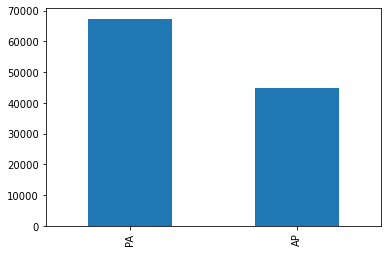

In [21]:
df['View Position'].value_counts().plot(kind = 'bar')

In [22]:
print(f'View position distribution\nPA: {len(position_PA)} ({100.0*len(position_PA)/len(df):.2f}%), AP: {len(df)} ({100.0*len(position_AP)/len(df):.2f}%)')

View position distribution
PA: 67299 (60.03%), AP: 112104 (39.97%)


The above shows that there are more PA view positions than AP

## Follow up

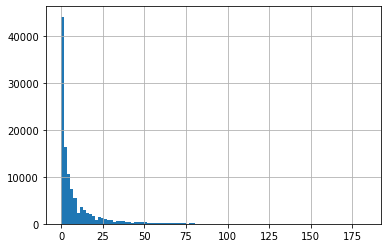

In [23]:
df['Follow-up #'].hist(bins=100)

The above histogram shows that most follow up numbers are at 0 which propably indicates this was the first visit. The distribution appears exponential.

In [24]:
df['Follow-up #'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [25]:
follow_up_0 = df[df['Follow-up #']==0]
print(f'Follow-up number 0 (first visit): {len(follow_up_0)} ({100.0*len(follow_up_0)/len(all_xray_df) :.2f}%)')

follow_up_1 = df[df['Follow-up #']==1]
print(f'Follow-up number 1 (second visit): {len(follow_up_1)} ({100.0*len(follow_up_1)/len(all_xray_df) :.2f}%)')

follow_up_2 = df[df['Follow-up #']==2]
print(f'Follow-up number 2 (second visit): {len(follow_up_2)} ({100.0*len(follow_up_2)/len(all_xray_df) :.2f}%)')

follow_up_3 = df[df['Follow-up #']==3]
print(f'Follow-up number 3 (second visit): {len(follow_up_3)} ({100.0*len(follow_up_3)/len(all_xray_df) :.2f}%)')

follow_up_4 = df[df['Follow-up #']==4]
print(f'Follow-up number 4 (second visit): {len(follow_up_4)} ({100.0*len(follow_up_4)/len(all_xray_df) :.2f}%)')

Follow-up number 0 (first visit): 30797 (27.47%)
Follow-up number 1 (second visit): 13301 (11.86%)
Follow-up number 2 (second visit): 9186 (8.19%)
Follow-up number 3 (second visit): 7088 (6.32%)
Follow-up number 4 (second visit): 5759 (5.14%)


## Patient ID

In [26]:
df['Patient ID'].nunique()

30802

There are 30,802 patients in this data set

## Finding Labels

In [27]:
len(df['Finding Labels'].unique())

836

The above shows 836 unique diagnoses. 

- Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
- per disease, with a binary flag. This makes EDA a lot easier! 


In [28]:
# generate pahtology_list showing 
pathology_list = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
#pahtology_list = [x for x in pathology_list if len(x)>0]
print(pathology_list)
for pathology in pathology_list:
    df[pathology] = df['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
df.head()

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
0                        0.143  ...          0         0       0   
1                        0.143  ...          1         0       0   
2                        0.168  ...          0         0       0   
3                        0.171  ...          0         0       0   
4                        0.143  ...          0         0       1   

   Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
0             0     0           0       0                   0          0   
1             0     0           0       0                   0          0   
2             0     0           0       0                   0          0   
3             0     0           1       0                   0          0   
4             0     0           0       0                   0          0   

   Pneumothorax  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 27 columns]

In [29]:
len(pathology_list)

15

In [30]:
df.shape

(112104, 27)

**Distributions of diseasese**

In [31]:
df[pathology_list].sum()/len(df)

Atelectasis           0.103101
Cardiomegaly          0.024763
Consolidation         0.041631
Edema                 0.020535
Effusion              0.118783
Emphysema             0.022443
Fibrosis              0.015040
Hernia                0.002025
Infiltration          0.177433
Mass                  0.051550
No Finding            0.538366
Nodule                0.056474
Pleural_Thickening    0.030186
Pneumonia             0.012756
Pneumothorax          0.047286
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

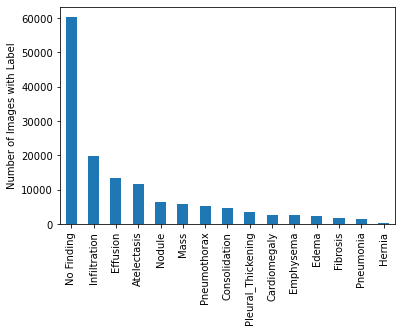

In [32]:
ax = df[pathology_list].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

The above shows relative frequencies of each disease in the sample dataset. It looks like 'No Finding' is the most common occurrence. 'No Finding' can never appear with any other label by definition, so we know that in 54.2% of this dataset, there is no finding in the image. Beyond that, it appears that 'Infiltration' is the most common disease-related label, and it is followed by 'Effusion' and 'Atelectasis.'

- No Finding            54.30%
- Infiltration          17.25%
- Effusion              11.49%
- Atelectasis           09.06%

**Create dataframes specific to Pneumonia and dig down to understand pneumonia Vs. Non pneumonia cases**

In [33]:
Pneumonia_df = df[df['Pneumonia']==1]
print('Number of pneumonia cases: ', len(df[df['Pneumonia']==1]))
print('Percentage of pneumonia cases in dataset: ', (len(df[df['Pneumonia']==1])/len(df)) * 100,'%')

Number of pneumonia cases:  1430
Percentage of pneumonia cases in dataset:  1.2756012274316706 %


In [34]:
no_Pneumonia_df = df[df['Pneumonia']==0]
print(len(df[df['Pneumonia']==0]), round(100.0*len(df[df['Pneumonia']==0])/len(df),2), "%")

110674 98.72 %


In [35]:
no_finding_0 = df[df['No Finding']==0]

In [36]:
print(len(df[df['No Finding']==1]), round(100.0*len(df[df['No Finding']==1])/len(df),2), "%")

60353 53.84 %


No finding is 53% fo the dataset 

**Age distribution with and without pneunomia**

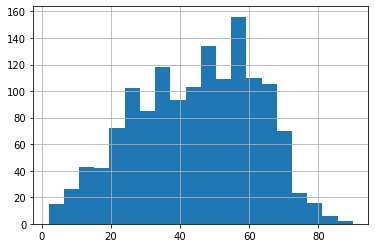

In [37]:
Pneumonia_df['Patient Age'].hist(bins=20)

In [38]:
Pneumonia_df['Patient Age'].describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

count       mean        std  min   25%   50%   75%   max
Pneumonia                                                             
0          110674.0  46.901025  16.582446  1.0  35.0  49.0  59.0  95.0
1            1430.0  44.670629  17.639098  2.0  31.0  46.0  59.0  90.0

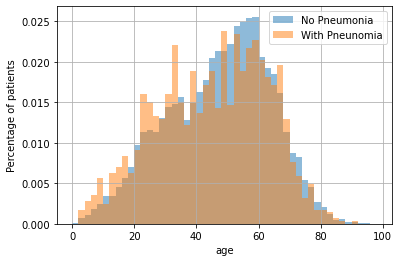

In [39]:
# Age distribution with and without pneunomia vs Gender
df.groupby(['Pneumonia'])['Patient Age'].hist(bins=np.arange(0,100,2), density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])
plt.ylabel('Percentage of patients')
plt.xlabel('age')
df.groupby(['Pneumonia'])['Patient Age'].describe()

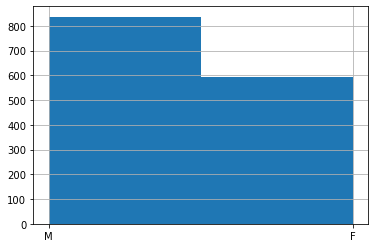

In [40]:
Pneumonia_df['Patient Gender'].hist(bins=2)

In [41]:
Pneumonia_df['Patient Gender'].describe()

count     1430
unique       2
top          M
freq       837
Name: Patient Gender, dtype: object

In [42]:
pneumonia_unique_patients_num = Pneumonia_df['Patient ID'].nunique()
print('Total pneumonia patients: ',pneumonia_unique_patients_num)

Total pneumonia patients:  1008


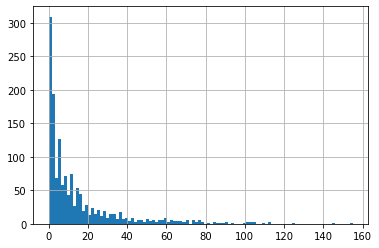

In [43]:
Pneumonia_df['Follow-up #'].hist(bins=100)

In [44]:
follow_up_0 = Pneumonia_df[Pneumonia_df['Follow-up #']==0]
print(f'Follow-up number 0 (first visit): {len(follow_up_0)} ({100.0*len(follow_up_0)/len(all_xray_df) :.2f}%)')

follow_up_1 = Pneumonia_df[Pneumonia_df['Follow-up #']==1]
print(f'Follow-up number 1 (second visit): {len(follow_up_1)} ({100.0*len(follow_up_1)/len(all_xray_df) :.2f}%)')

follow_up_2 = Pneumonia_df[Pneumonia_df['Follow-up #']==2]
print(f'Follow-up number 2 (second visit): {len(follow_up_2)} ({100.0*len(follow_up_2)/len(all_xray_df) :.2f}%)')

follow_up_3 = Pneumonia_df[Pneumonia_df['Follow-up #']==3]
print(f'Follow-up number 3 (second visit): {len(follow_up_3)} ({100.0*len(follow_up_3)/len(all_xray_df) :.2f}%)')

follow_up_4 = Pneumonia_df[Pneumonia_df['Follow-up #']==4]
print(f'Follow-up number 4 (second visit): {len(follow_up_4)} ({100.0*len(follow_up_4)/len(all_xray_df) :.2f}%)')

Follow-up number 0 (first visit): 177 (0.16%)
Follow-up number 1 (second visit): 132 (0.12%)
Follow-up number 2 (second visit): 114 (0.10%)
Follow-up number 3 (second visit): 79 (0.07%)
Follow-up number 4 (second visit): 68 (0.06%)


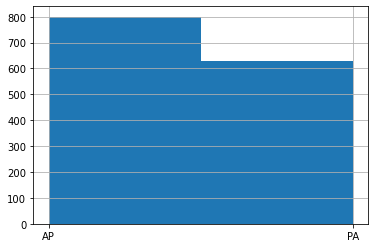

In [45]:
Pneumonia_df['View Position'].hist(bins=2)


**Distribution of other diseases that are comorbid with pneumonia**

[Text(0, 0.5, 'Number of Images with Label')]

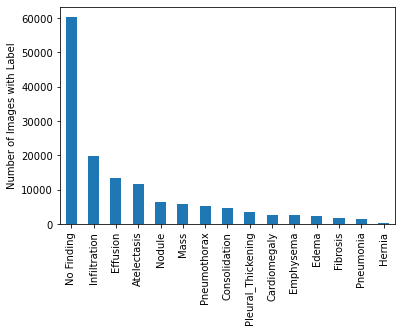

In [46]:
ax = df[pathology_list].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

Since 'Infiltration' is the most common, I'm going to now look at how frequently it appears with all of the other diseases: 

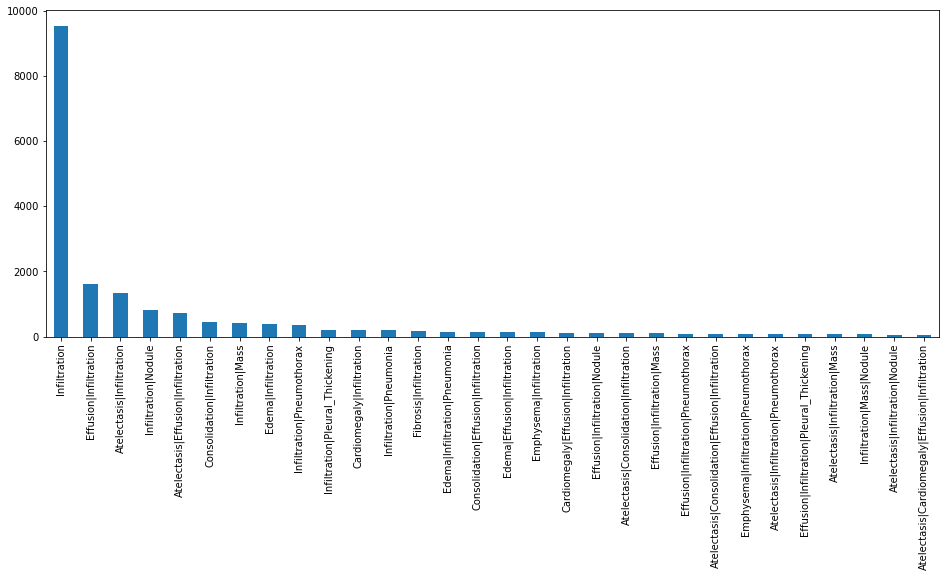

In [47]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df[df.Infiltration==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Infiltration actually occurs alone for the most part, and that its most-common comorbidities are Atelectasis and Effusion. 

Let's see if the same is true for another label, we'll try Effusion:

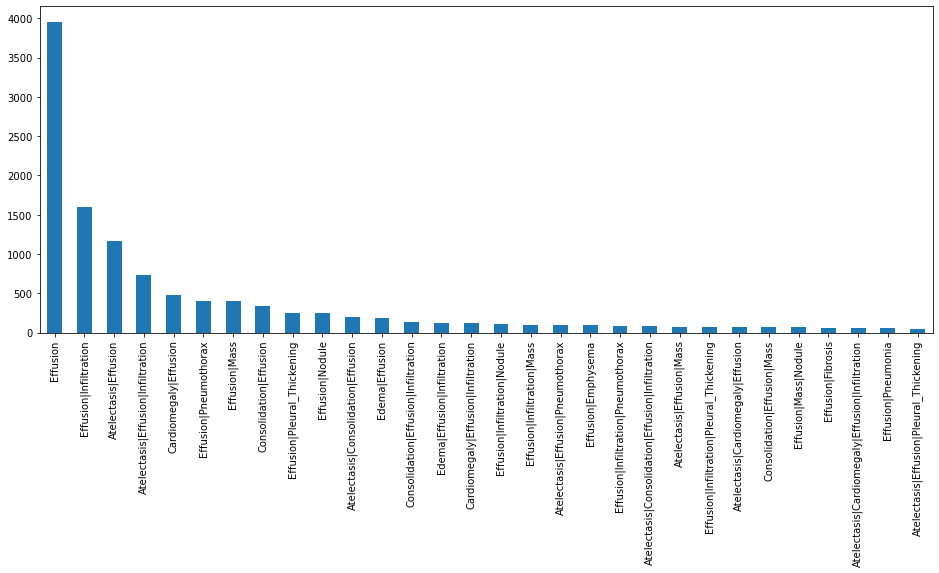

In [48]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df[df.Effusion==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Infiltration actually occurs alone for the most part, and that its most-common comorbidities are Effusion and Atelectasis. 

Let's see if the same is true for another label, we'll try Pneumonia:

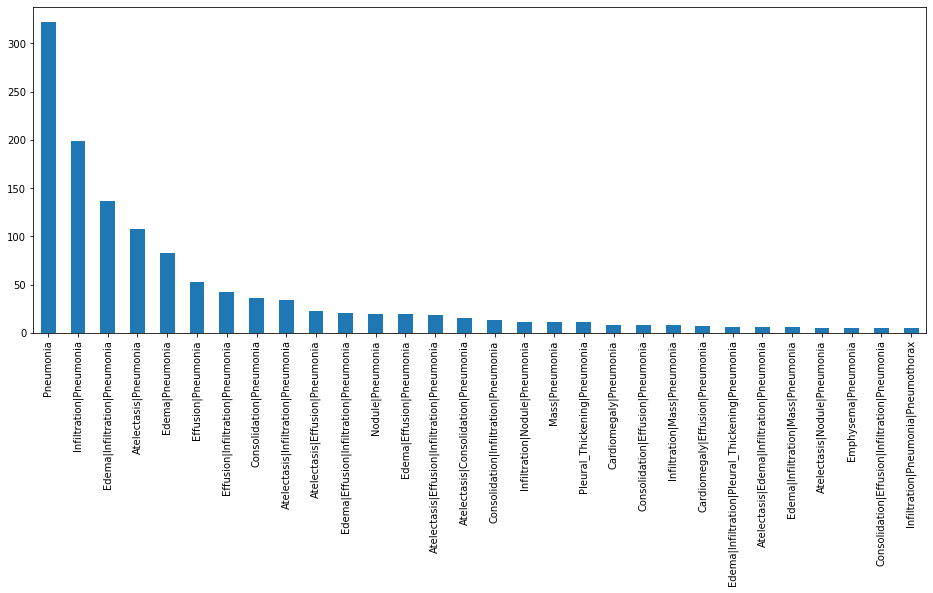

In [49]:
plt.figure(figsize=(16,6))
df[df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

In [50]:
df[df['Pneumonia']==1]['Finding Labels'].value_counts()[0:30]

Pneumonia                                          322
Infiltration|Pneumonia                             199
Edema|Infiltration|Pneumonia                       137
Atelectasis|Pneumonia                              108
Edema|Pneumonia                                     83
Effusion|Pneumonia                                  53
Effusion|Infiltration|Pneumonia                     42
Consolidation|Pneumonia                             36
Atelectasis|Infiltration|Pneumonia                  34
Atelectasis|Effusion|Pneumonia                      23
Edema|Effusion|Infiltration|Pneumonia               21
Nodule|Pneumonia                                    19
Edema|Effusion|Pneumonia                            19
Atelectasis|Effusion|Infiltration|Pneumonia         18
Atelectasis|Consolidation|Pneumonia                 15
Consolidation|Infiltration|Pneumonia                13
Infiltration|Nodule|Pneumonia                       11
Mass|Pneumonia                                      11
Pleural_Th

In [51]:
df[df['Pneumonia']==1]['Finding Labels'].value_counts().sum()

1430

Frequency of comorbid conditions with pneumonia (per each condition)

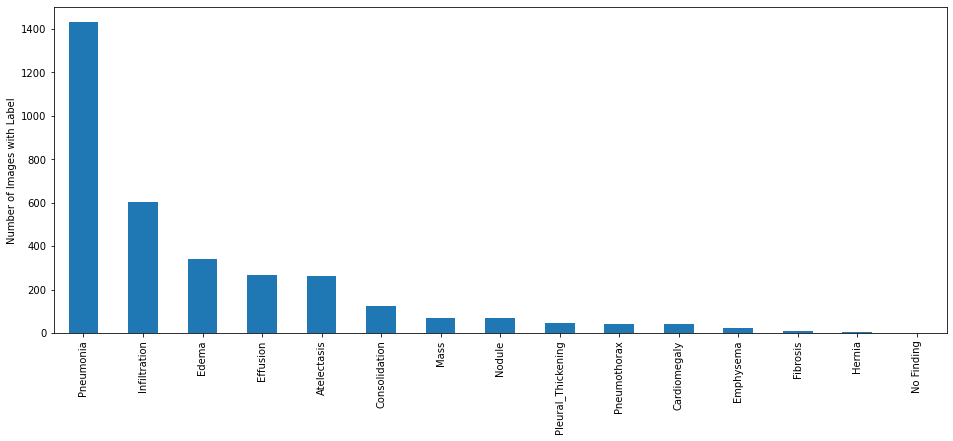

In [52]:
plt.figure(figsize=(16,6))
ax = Pneumonia_df[pathology_list].sum().sort_values(ascending=False).plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')
plt.show()

**Number of disease per patient**

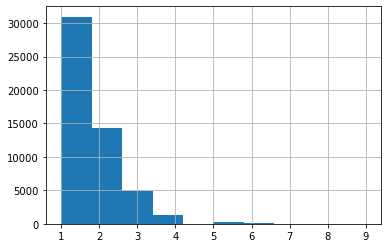

In [53]:
no_finding_0[pathology_list].sum(axis=1).hist(bins=10)

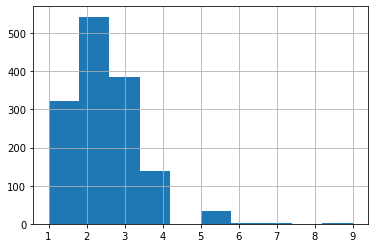

In [54]:
Pneumonia_df[pathology_list].sum(axis=1).hist(bins=10)

For the most part the data set contains mostly a single diagnoses however pneumonia is usually accompanied with something else. Below is a bar chart that shows the top 5

- Infiltration|Pneumonia 
- Edema|Infiltration|Pneumonia
- Atelectasis|Pneumonia
- Edema|Pneumonia
- Effusion|Pneumonia

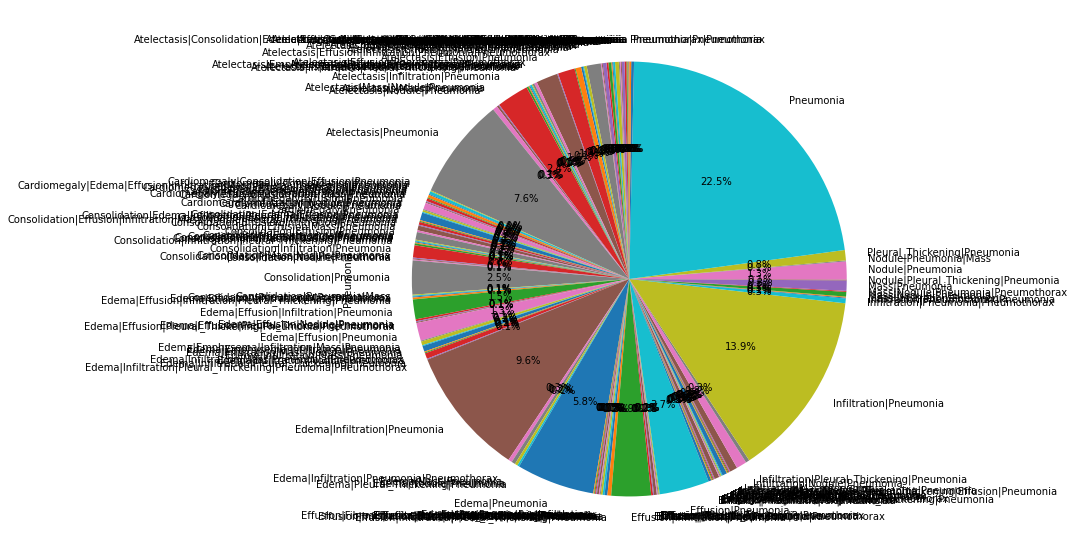

In [55]:
Pneumonia_df.groupby(['Finding Labels']).sum().plot(kind='pie', y='Pneumonia',figsize=(10, 10), legend=False, startangle=90, autopct='%1.1f%%')

In [56]:
#print(len(Pneumonia_df[Pneumonia_df['Finding Labels']=='Infiltration|Pneumonia']), round(100.0*len(Pneumonia_df[Pneumonia_df['Finding Labels']=='Infiltration|Pneumonia'])/len(Pneumonia_df),2), "%")

**Patient Age Distribution for reference**

Text(0.5, 1.0, 'Patient Age Distribution for reference')

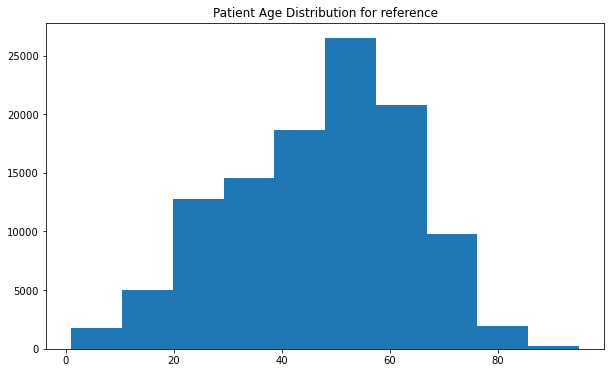

In [57]:
plt.figure(figsize=(10,6))
plt.hist(df['Patient Age'])
plt.title('Patient Age Distribution for reference')

**Infiltration Vs. Patient Age Distribution**

Text(0.5, 1.0, 'Infiltration Vs. Patient Age Distribution')

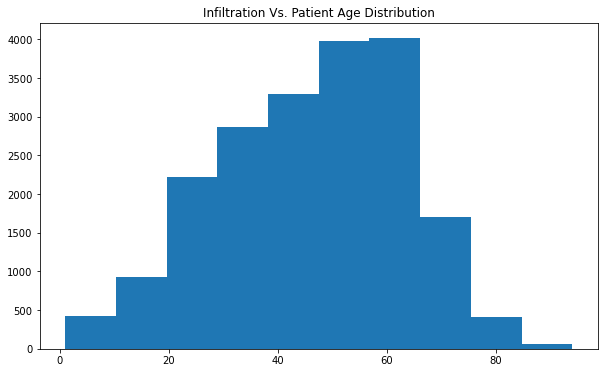

In [58]:
plt.figure(figsize=(10,6))
plt.hist(df[df.Infiltration==1]['Patient Age'])
plt.title('Infiltration Vs. Patient Age Distribution')

**Effusion Vs. Patient Age Distribution**

Text(0.5, 1.0, 'Effusion Vs. Patient Age Distribution')

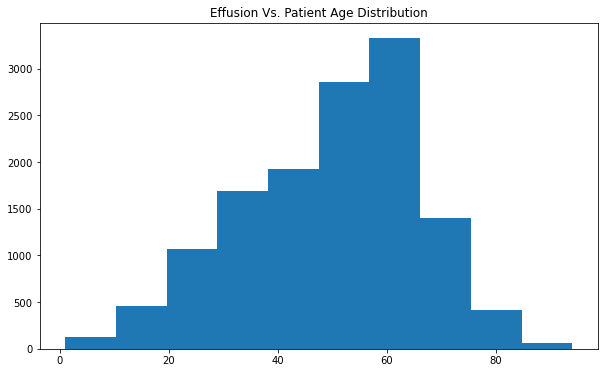

In [59]:
plt.figure(figsize=(10,6))
plt.hist(df[df.Effusion==1]['Patient Age'])
plt.title('Effusion Vs. Patient Age Distribution')

Looks like the distribution of age across the whole population is slightly different than it is specifically for Infiltration and Effusion. Effusion appears to be more skewed towards younger individuals, and Infiltration spans the age range but has a large peak around 60. 

Text(0.5, 1.0, 'Patient Gender')

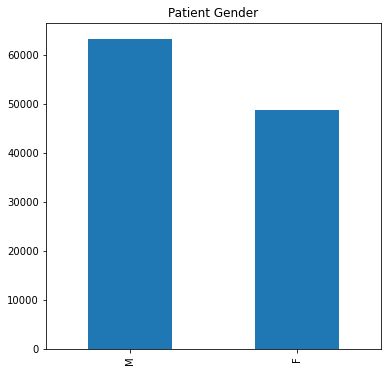

In [60]:
plt.figure(figsize=(6,6))
df['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Patient Gender')

Text(0.5, 1.0, 'Infiltration Vs. Patient Gender')

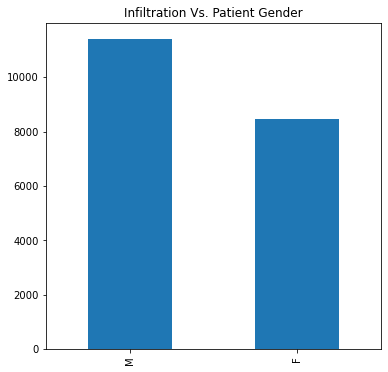

In [61]:
plt.figure(figsize=(6,6))
df[df.Infiltration ==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Infiltration Vs. Patient Gender')

Text(0.5, 1.0, 'Effusion Vs. Patient Gender')

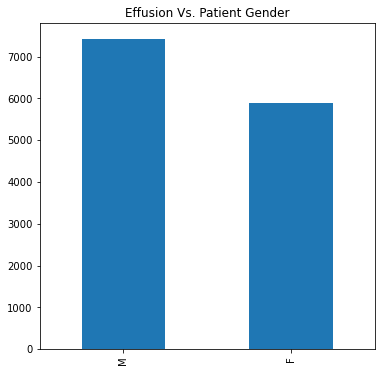

In [62]:
plt.figure(figsize=(6,6))
df[df.Effusion ==1]['Patient Gender'].value_counts().plot(kind='bar')
plt.title('Effusion Vs. Patient Gender')

Gender distribution shows a slight preference towards males for both Infiltration and Effusion.

**Each desease by patient**

Text(0.5, 1.0, '')

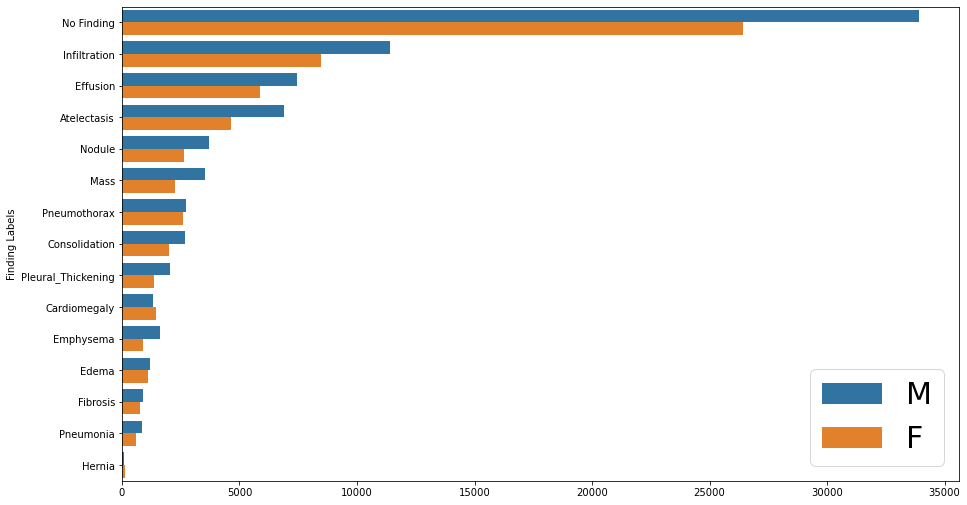

In [63]:
plt.figure(figsize = (15, 10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
data1 = pd.melt(df,
                id_vars = ['Patient Gender'],
                value_vars = list(pathology_list),
                var_name = 'Category', 
                value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category', hue='Patient Gender', data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set(ylabel="Finding Labels", xlabel="")
ax1.legend(fontsize = 30)
ax1.set_title('')

age distribution by sex

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


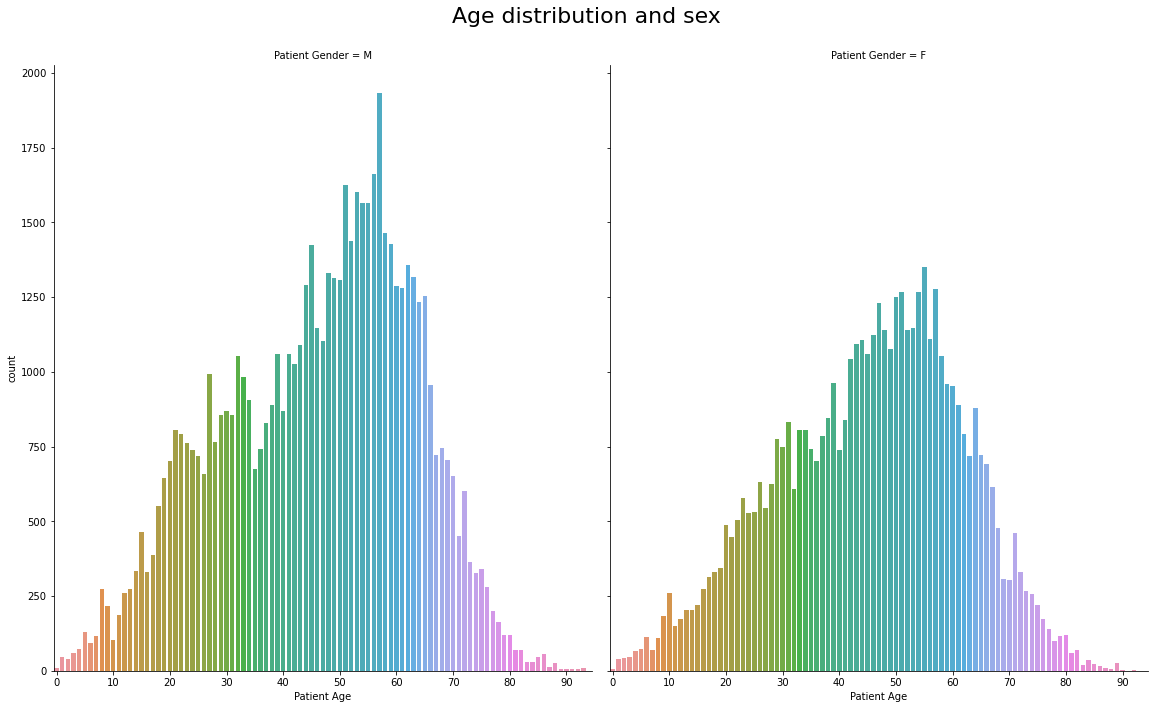

In [64]:
g = sns.catplot(x="Patient Age", col="Patient Gender",data=df, kind="count",size=10, aspect=0.8,palette=None, sharex=False);
g.set_xticklabels(np.arange(0,100));
g.set_xticklabels(step=10);
g.fig.suptitle('Age distribution and sex',fontsize=22);
g.fig.subplots_adjust(top=.9)

**Disease distribution by age and sex**

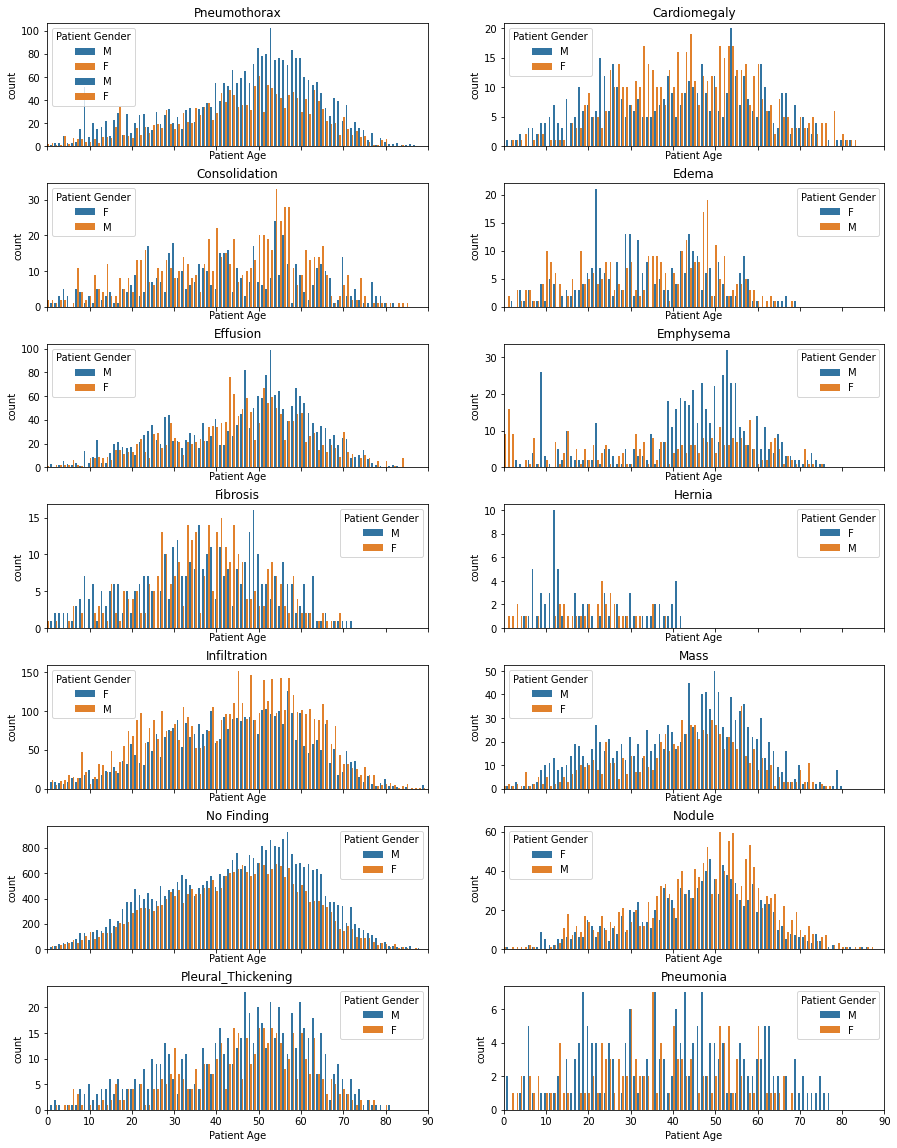

In [65]:
f, axarr = plt.subplots(7, 2, sharex=True, figsize=(15,20))

i = 0
j = 0
x = np.arange(0,100,10)
for pathology in pathology_list:
    g = sns.countplot(x = 'Patient Age', hue="Patient Gender", data=df[df['Finding Labels']==pathology], ax=axarr[i, j])
    axarr[i, j].set_title(pathology)
    g.set_xlim(0, 90)
    g.set_xticks(x)
    g.set_xticklabels(x)
    j=(j+1)%2
    if j==0:
        i=(i+1)%7
f.subplots_adjust(hspace=0.3)

**Correlation between Pathologies**

In [66]:
data = df.groupby('Finding Labels').count().sort_values('Patient ID', ascending=False).head(23)
data = data[['|' in index for index in data.index.values]]
data

Image Index  Follow-up #  Patient ID  \
Finding Labels                                                            
Effusion|Infiltration                     1603         1603        1603   
Atelectasis|Infiltration                  1350         1350        1350   
Atelectasis|Effusion                      1165         1165        1165   
Infiltration|Nodule                        829          829         829   
Atelectasis|Effusion|Infiltration          737          737         737   
Cardiomegaly|Effusion                      484          484         484   
Consolidation|Infiltration                 441          441         441   
Infiltration|Mass                          418          418         418   
Effusion|Pneumothorax                      403          403         403   
Effusion|Mass                              402          402         402   

                                   Patient Age  Patient Gender  View Position  \
Finding Labels                                                                  
Effusion|Infiltration                     1603            1603           1603   
Atelectasis|Infiltration                  1350            1350           1350   
Atelectasis|Effusion                      1165            1165           1165   
Infiltration|Nodule                        829             829            829   
Atelectasis|Effusion|Infiltration          737             737            737   
Cardiomegaly|Effusion                      484             484            484   
Consolidation|Infiltration                 441             441            441   
Infiltration|Mass                          418             418            418   
Effusion|Pneumothorax                      403             403            403   
Effusion|Mass                              402             402            402   

                                   OriginalImage[Width  Height]  \
Finding Labels                                                    
Effusion|Infiltration                             1603     1603   
Atelectasis|Infiltration                          1350     1350   
Atelectasis|Effusion                              1165     1165   
Infiltration|Nodule                                829      829   
Atelectasis|Effusion|Infiltration                  737      737   
Cardiomegaly|Effusion                              484      484   
Consolidation|Infiltration                         441      441   
Infiltration|Mass                                  418      418   
Effusion|Pneumothorax                              403      403   
Effusion|Mass                                      402      402   

                                   OriginalImagePixelSpacing[x    y]  ...  \
Finding Labels                                                        ...   
Effusion|Infiltration                                     1603  1603  ...   
Atelectasis|Infiltration                                  1350  1350  ...   
Atelectasis|Effusion                                      1165  1165  ...   
Infiltration|Nodule                                        829   829  ...   
Atelectasis|Effusion|Infiltration                          737   737  ...   
Cardiomegaly|Effusion                                      484   484  ...   
Consolidation|Infiltration                                 441   441  ...   
Infiltration|Mass                                          418   418  ...   
Effusion|Pneumothorax                                      403   403  ...   
Effusion|Mass                                              402   402  ...   

                                   Emphysema  Fibrosis  Hernia  Infiltration  \
Finding Labels                                                                 
Effusion|Infiltration                   1603      1603    1603          1603   
Atelectasis|Infiltration                1350      1350    1350          1350   
Atelectasis|Effusion                    1165      1165    1165          1165   
Infiltration|Nodule            

In [67]:
data = df.groupby('Finding Labels').count().sort_values('Patient ID', ascending=False)
df1 = data[['|' in index for index in data.index]].copy()
df2 = data[['|' not in index for index in data.index]]
df2 = df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

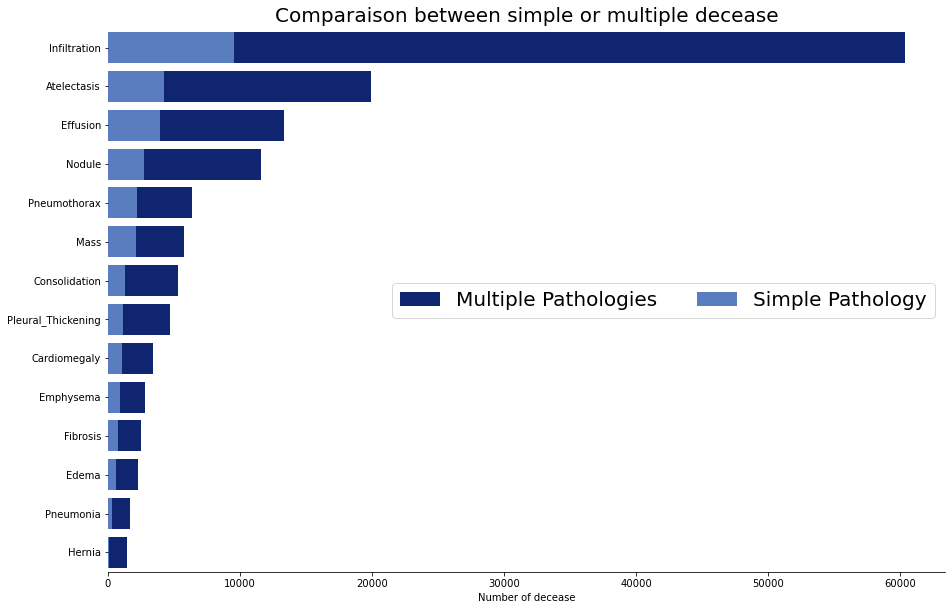

In [68]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("dark")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="b",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=20)
ax.set( ylabel="",xlabel="Number of decease")
ax.set_title("Comparaison between simple or multiple decease",fontsize=20)      
sns.despine(left=True)

/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:280: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/conda/lib/python3.7/site-packages/seaborn/matrix.py:280: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


(array([], dtype=float64), <a list of 0 Text major ticklabel objects>)

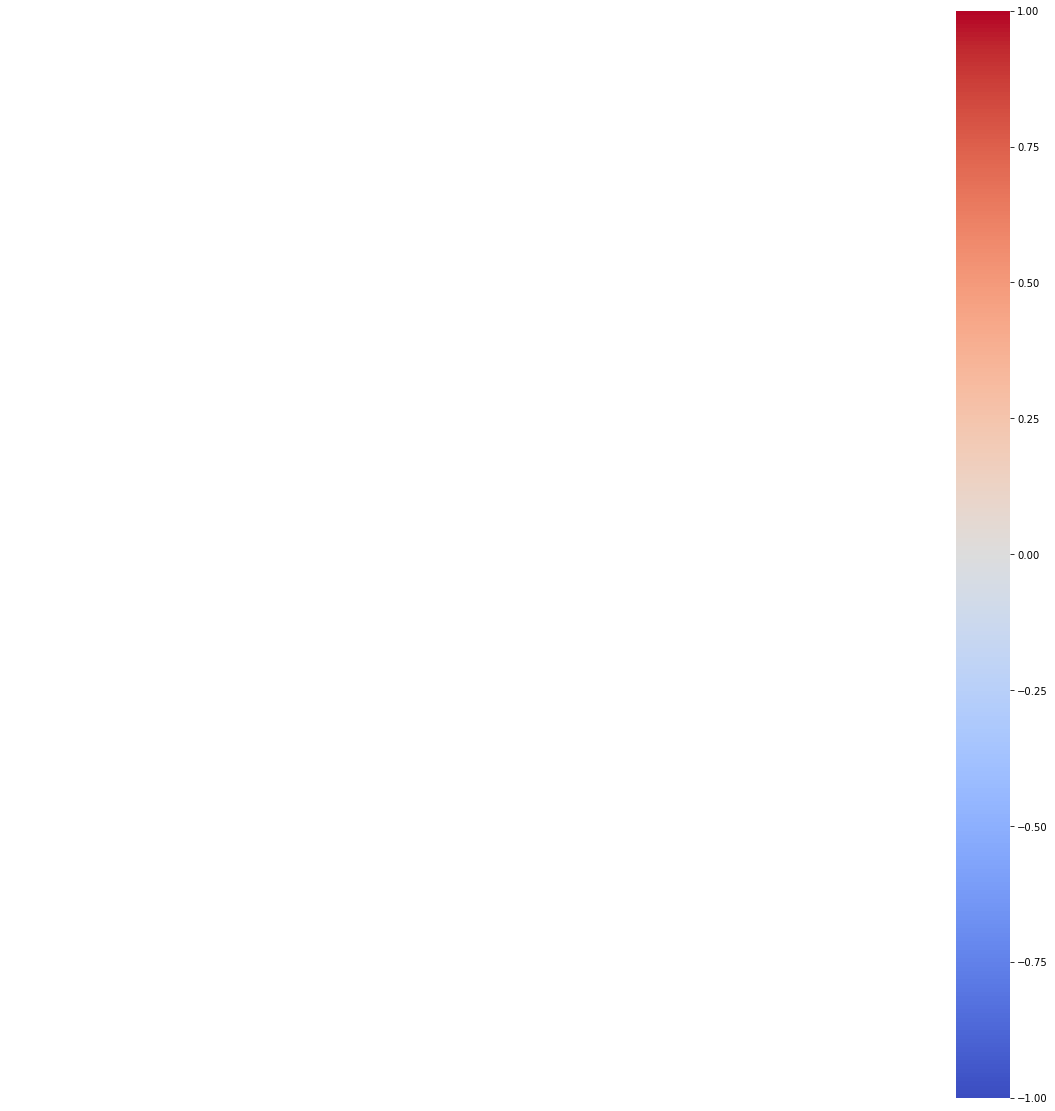

In [69]:
plt.figure(figsize=(20, 20))
mask = np.tril(sample_df.iloc[:, 12:26].corr())
sns.heatmap(sample_df.iloc[:, 12:26].corr(), annot=True, xticklabels=1, yticklabels=1, annot_kws={"size":14}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=.1, linecolor='black')
#sns.heatmap(sample_df.iloc[:, 12:26].corr(), annot=True, mask=mask, xticklabels=1, yticklabels=1, annot_kws={"size":14}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=.1, linecolor='black')
#sns.heatmap(df_s.iloc[:, 12:26].corr(), mask=mask, xticklabels=1, yticklabels=1, annot=True, annot_kws={"size":14}, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=.1, linecolor='black')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yticks(rotation=0)  
plt.xticks(rotation=90)

In [70]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head()

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   

                                   Atelectasis  Cardiomegaly  Consolidation  \
Finding Labels                                                                
Effusion|Infiltration                        0             0              0   
Atelectasis|Infiltration                  1350             0              0   
Atelectasis|Effusion                      1165             0              0   
Infiltration|Nodule                          0             0              0   
Atelectasis|Effusion|Infiltration          737             0              0   

                                   Edema  Effusion  Emphysema  Fibrosis  \
Finding Labels                                                            
Effusion|Infiltration                  0      1603          0         0   
Atelectasis|Infiltration               0         0          0         0   
Atelectasis|Effusion                   0      1165          0         0   
Infiltration|Nodule                    0         0          0         0   
Atelectasis|Effusion|Infiltration      0       737          0         0   

                                   Hernia  Infiltration  Mass  No Finding  \
Finding Labels                                                              
Effusion|Infiltration                   0          1603     0           0   
Atelectasis|Infiltration                0          1350     0           0   
Atelectasis|Effusion                    0             0     0           0   
Infiltration|Nodule                     0           829     0           0   
Atelectasis|Effusion|Infiltration       0           737     0           0   

                                   Nodule  Pleural_Thickening  Pneumonia  \
Finding Labels                                                             
Effusion|Infiltration                   0                   0          0   
Atelectasis|Infiltration                0                   0          0   
Atelectasis|Effusion                    0                   0          0   
Infiltration|Nodule                   829                   0          0   
Atelectasis|Effusion|Infiltration       0                   0          0   

                                   Pneumothorax  
Finding Labels                                   
Effusion|Infiltration                         0  
Atelectasis|Infiltration                      0  
Atelectasis|Effusion                          0  
Infiltration|Nodule                           0  
Atelectasis|Effusion|Infiltration             0

In [71]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)

Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   
Cardiomegaly|Effusion                     484   
Consolidation|Infiltration                441   
Infiltration|Mass                         418   
Effusion|Pneumothorax                     403   
Effusion|Mass                             402   
Atelectasis|Consolidation                 398   
Mass|Nodule                               394   
Edema|Infiltration                        392   
Infiltration|Pneumothorax                 345   
Consolidation|Effusion                    337   
Emphysema|Pneumothorax                    337   
Effusion|Pleural_Thickening               251   
Effusion|Nodule                           249   
Atelectasis|Pneumothorax                  240   
Infiltration|Pleural_Thickening           210   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   
Cardiomegaly|Effusion                          Cardiomegaly|Effusion   
Consolidation|Infiltration                Consolidation|Infiltration   
Infiltration|Mass                                  Infiltration|Mass   
Effusion|Pneumothorax                          Effusion|Pneumothorax   
Effusion|Mass                                          Effusion|Mass   
Atelectasis|Consolidation                  Atelectasis|Consolidation   
Mass|Nodule                                              Mass|Nodule   
Edema|Infiltration                                Edema|Infiltration   
Infiltration|Pneumothorax                  Infiltration|Pneumothorax   
Consolidation|Effusion                        Consolidation|Effusion   
Emphysema|Pneumothorax                        Emphysema|Pneumothorax   
Effusion|Pleural_Thickening              Effusion|Pleural_Thickening   
Effusion|Nodule                                      Effusion|Nodule   
Atelectasis|Pneumothorax                    Atelectasis|Pneumothorax   
Infiltration|Pleural_Thickening      Infiltration|Pleural_Thickening   

                                   Atelectasis  Cardiomegaly  Consolidation  \
Finding Labels                                                                
Effusion|Infiltration                        0             0              0   
Atelectasis|Infiltration                  1350             0              0   
Atelectasis|Effusion                      1165             0              0   
Infiltration|Nodule                          0             0              0   
Atelectasis|Effusion|Infiltration          737             0              0   
Cardiomegaly|Effusion                        0           484              0   
Consolidation|Infiltration                   0             0            441   
Infiltration|Mass                            0             0              0   
Effusion|Pneumothorax                        0             0              0   
Effusion|Mass                                0             0              0   
Atelectasis|Consolidation                  398             0            398   
Mass|Nodule                                  0             0              0   
Edema|Infiltration                           0             0              0   
Infiltration|Pneumothorax                    0             0              0   
Consolidation|Effusion                       0             0            337   
Emphysema|Pneumothorax      

In [72]:
#we just keep groups of pathologies which appear more than 30 times
df3=df1.loc[df1['Patient ID']>30,['Patient ID','Finding Labels']]

for pathology in pathology_list:
    df3[pathology]=df3.apply(lambda x: x['Patient ID'] if pathology in x['Finding Labels'] else 0, axis=1)

df3.head(20)


Patient ID  \
Finding Labels                                  
Effusion|Infiltration                    1603   
Atelectasis|Infiltration                 1350   
Atelectasis|Effusion                     1165   
Infiltration|Nodule                       829   
Atelectasis|Effusion|Infiltration         737   
Cardiomegaly|Effusion                     484   
Consolidation|Infiltration                441   
Infiltration|Mass                         418   
Effusion|Pneumothorax                     403   
Effusion|Mass                             402   
Atelectasis|Consolidation                 398   
Mass|Nodule                               394   
Edema|Infiltration                        392   
Infiltration|Pneumothorax                 345   
Consolidation|Effusion                    337   
Emphysema|Pneumothorax                    337   
Effusion|Pleural_Thickening               251   
Effusion|Nodule                           249   
Atelectasis|Pneumothorax                  240   
Infiltration|Pleural_Thickening           210   

                                                      Finding Labels  \
Finding Labels                                                         
Effusion|Infiltration                          Effusion|Infiltration   
Atelectasis|Infiltration                    Atelectasis|Infiltration   
Atelectasis|Effusion                            Atelectasis|Effusion   
Infiltration|Nodule                              Infiltration|Nodule   
Atelectasis|Effusion|Infiltration  Atelectasis|Effusion|Infiltration   
Cardiomegaly|Effusion                          Cardiomegaly|Effusion   
Consolidation|Infiltration                Consolidation|Infiltration   
Infiltration|Mass                                  Infiltration|Mass   
Effusion|Pneumothorax                          Effusion|Pneumothorax   
Effusion|Mass                                          Effusion|Mass   
Atelectasis|Consolidation                  Atelectasis|Consolidation   
Mass|Nodule                                              Mass|Nodule   
Edema|Infiltration                                Edema|Infiltration   
Infiltration|Pneumothorax                  Infiltration|Pneumothorax   
Consolidation|Effusion                        Consolidation|Effusion   
Emphysema|Pneumothorax                        Emphysema|Pneumothorax   
Effusion|Pleural_Thickening              Effusion|Pleural_Thickening   
Effusion|Nodule                                      Effusion|Nodule   
Atelectasis|Pneumothorax                    Atelectasis|Pneumothorax   
Infiltration|Pleural_Thickening      Infiltration|Pleural_Thickening   

                                   Atelectasis  Cardiomegaly  Consolidation  \
Finding Labels                                                                
Effusion|Infiltration                        0             0              0   
Atelectasis|Infiltration                  1350             0              0   
Atelectasis|Effusion                      1165             0              0   
Infiltration|Nodule                          0             0              0   
Atelectasis|Effusion|Infiltration          737             0              0   
Cardiomegaly|Effusion                        0           484              0   
Consolidation|Infiltration                   0             0            441   
Infiltration|Mass                            0             0              0   
Effusion|Pneumothorax                        0             0              0   
Effusion|Mass                                0             0              0   
Atelectasis|Consolidation                  398             0            398   
Mass|Nodule                                  0             0              0   
Edema|Infiltration                           0             0              0   
Infiltration|Pneumothorax                    0             0              0   
Consolidation|Effusion                       0             0            337   
Emphysema|Pneumothorax      

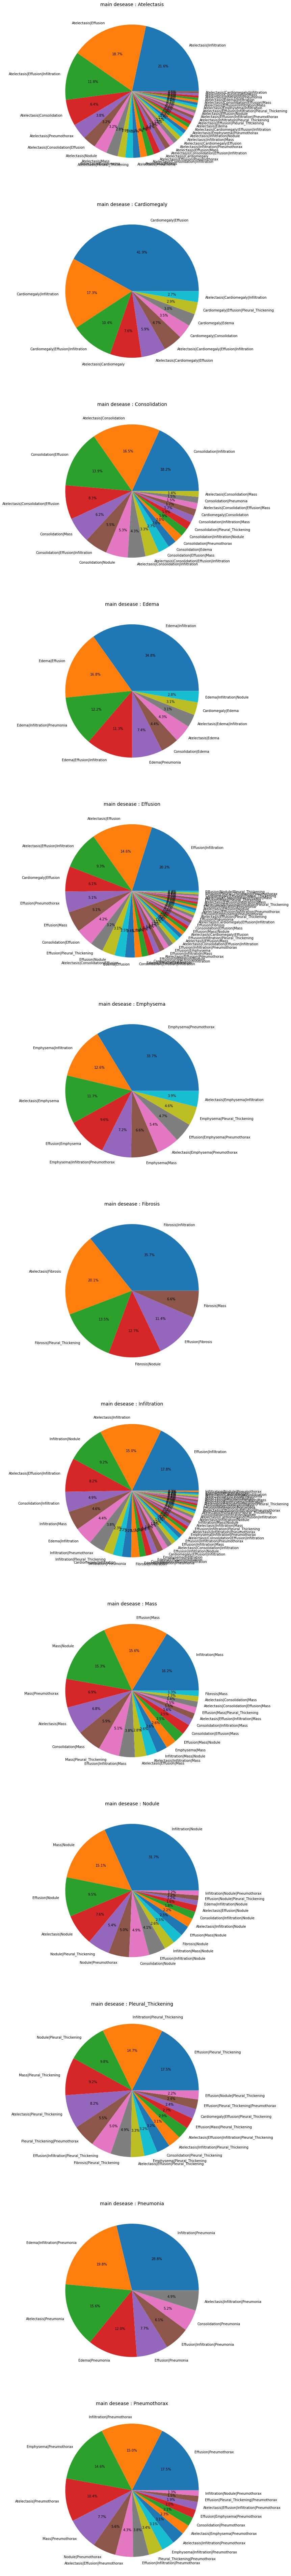

In [73]:
#'Hernia' has not enough values to figure here
df4=df3[df3['Hernia']>0]  # df4.size == 0
#remove 'Hernia' from list
pat_list=[elem for elem in pathology_list if 'Hernia' not in elem]

f, axarr = plt.subplots(13, sharex=True,figsize=(10, 140))
i=0
for pathology in pat_list :
    df4=df3[df3[pathology]>0]
    if df4.size>0:  #'Hernia' has not enough values to figure here
        axarr[i].pie(df4[pathology],labels=df4['Finding Labels'], autopct='%1.1f%%')
        axarr[i].set_title('main desease : '+pathology,fontsize=14)   
        i +=1



We can see that some pathologies seem to appear with all kind of other diseaseses:

-    Effusion
-    Aletectasis
-    Infiltration 
    
Some others seem to have favorite couple:

-    Cardiomegaly with Effusion
-    Emphysema with Pneumothorax
-    Nodule with Infiltration
-    Edema with Infiltration
-    Fibrosis with Infiltration
-    Pneumonia with Infiltration



**Pixel-level assessments of the imaging data for healthy & disease states of interest.(e.g. histograms of intensity values) and compare distributions across diseases.**

In [74]:
sample_df.head(3)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  \
0                3056                 2544                        0.139   
1                2500                 2048                        0.168   
2                2500                 2048                        0.168   

   OriginalImagePixelSpacing_y  
0                        0.139  
1                        0.168  
2                        0.168

In [75]:
findings = set()
for finding in all_xray_df['Finding Labels'].unique():
    findings.update(finding.split('|'))
print("Single diagnoses qty:", len(findings), findings)

Single diagnoses qty: 15 {'Mass', 'Consolidation', 'Cardiomegaly', 'Nodule', 'Pneumonia', 'Effusion', 'Infiltration', 'Atelectasis', 'Pneumothorax', 'Hernia', 'Edema', 'Pleural_Thickening', 'Emphysema', 'No Finding', 'Fibrosis'}


In [76]:
for finding in findings:
    sample_df[finding] = sample_df['Finding Labels'].map(lambda x: 1.0 if finding in x else 0)

sample_df.head(5)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Effusion  Infiltration  Atelectasis  Pneumothorax  Hernia  Edema  \
0       0.0           1.0          0.0           1.0     0.0    0.0   
1       0.0           0.0          0.0           0.0     0.0    0.0   
2       0.0           0.0          0.0           0.0     0.0    0.0   
3       0.0           0.0          1.0           0.0     0.0    0.0   
4       1.0           0.0          0.0           0.0     0.0    1.0   

   Pleural_Thickening  Emphysema  No Finding  Fibrosis  
0                 1.0        1.0         0.0       0.0  
1                 0.0        1.0         0.0       0.0  
2                 0.0        0.0         1.0       0.0  
3                 0.0        0.0         0.0       0.0  
4                 0.0        0.0         0.0       0.0  

[5 rows x 26 columns]

In [77]:
sample_df.shape

(5606, 26)

In [78]:
def get_image_path(row):
    fpath = None
    f = row['Image Index']
    for d in range(12):
        dname = 'images_' + str(d).zfill(3)
        fname = '/data/' + dname + '/images/' + f
        if os.path.isfile(fname):
            fpath = fname
            break
    return fpath

sample_df['image_path'] = sample_df.apply(get_image_path, axis=1)
sample_df.head(5)

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Infiltration  Atelectasis  Pneumothorax  Hernia  Edema  Pleural_Thickening  \
0           1.0          0.0           1.0     0.0    0.0                 1.0   
1           0.0          0.0           0.0     0.0    0.0                 0.0   
2           0.0          0.0           0.0     0.0    0.0                 0.0   
3           0.0          1.0           0.0     0.0    0.0                 0.0   
4           0.0          0.0           0.0     0.0    1.0                 0.0   

   Emphysema  No Finding  Fibrosis                                image_path  
0        1.0         0.0       0.0  /data/images_001/images/00000013_005.png  
1        1.0         0.0       0.0  /data/images_001/images/00000013_026.png  
2        0.0         1.0       0.0  /data/images_001/images/00000017_001.png  
3        0.0         0.0       0.0  /data/images_001/images/00000030_001.png  
4        0.0         0.0       0.0  /data/images_001/images/00000032_001.png  

[5 rows x 27 columns]

In [79]:
pneumo_samples = sample_df[sample_df['Pneumonia'] == 1]
len(pneumo_samples)

62

In [80]:
pneumonia_example_1 = pneumo_samples.iloc[0]
pneumonia_example_1

Image Index                                            00001373_010.png
Finding Labels                          Cardiomegaly|Effusion|Pneumonia
Follow-up #                                                          10
Patient ID                                                         1373
Patient Age                                                        058Y
Patient Gender                                                        M
View Position                                                        AP
OriginalImageWidth                                                 3056
OriginalImageHeight                                                2544
OriginalImagePixelSpacing_x                                       0.139
OriginalImagePixelSpacing_y                                       0.139
Mass                                                                  0
Consolidation                                                         0
Cardiomegaly                                                    

In [81]:
def show_image_distr(img_data):
    f = plt.figure()
    f.set_figwidth(10)

    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')


    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)

    plt.show()

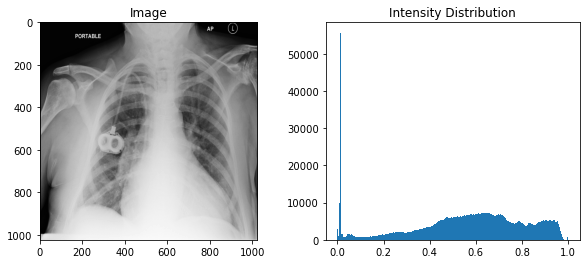

In [82]:
ex1_data = image.imread('/data/images_002/images/' + pneumonia_example_1['Image Index'])
show_image_distr(ex1_data)

In [83]:
def get_image_data(row):
    fpath = row['image_path']
    if fpath is not None:
        img = image.imread(fpath)
        return img
    else:
        return None

In [84]:
pneumo_samples['image_data'] = pneumo_samples.apply(get_image_data, axis=1)
pneumo_samples.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Image Index                        Finding Labels  Follow-up #  \
256  00001373_010.png       Cardiomegaly|Effusion|Pneumonia           10   
287  00001529_004.png  Consolidation|Infiltration|Pneumonia            4   

     Patient ID Patient Age Patient Gender View Position  OriginalImageWidth  \
256        1373        058Y              M            AP                3056   
287        1529        054Y              F            PA                2992   

     OriginalImageHeight  OriginalImagePixelSpacing_x  ...  Atelectasis  \
256                 2544                        0.139  ...          0.0   
287                 2991                        0.143  ...          0.0   

     Pneumothorax  Hernia  Edema  Pleural_Thickening  Emphysema  No Finding  \
256           0.0     0.0    0.0                 0.0        0.0         0.0   
287           0.0     0.0    0.0                 0.0        0.0         0.0   

     Fibrosis                                image_path  \
256       0.0  /data/images_002/images/00001373_010.png   
287       0.0  /data/images_002/images/00001529_004.png   

                                            image_data  
256  [[0.0, 0.003921569, 0.007843138, 0.007843138, ...  
287  [[0.91764706, 0.89411765, 0.8509804, 0.7960784...  

[2 rows x 28 columns]

In [85]:
pneumo_data = pneumo_samples[pneumo_samples['image_data'].notna()]['image_data'].values
pneumo_data.shape

(60,)

In [86]:
pneumo_intensities = []
for data in pneumo_data:
    pneumo_intensities.extend(data.flatten().tolist())

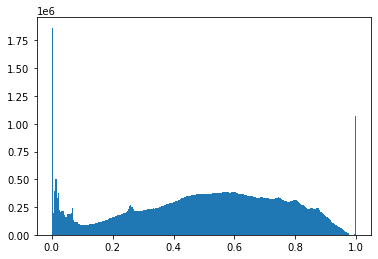

In [87]:
plt.hist(pneumo_intensities,bins=256)
plt.show()

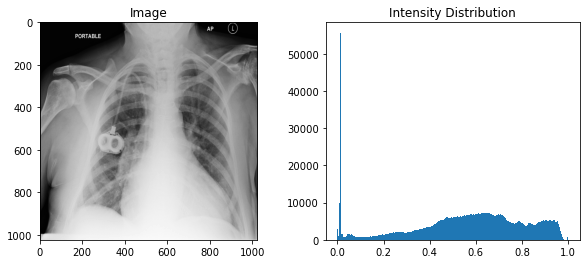

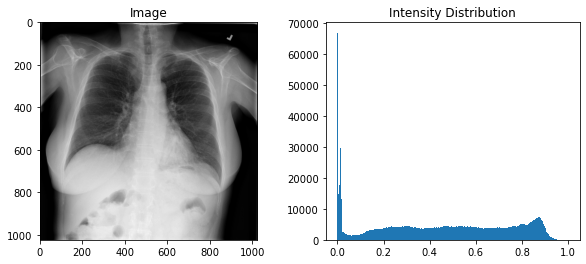

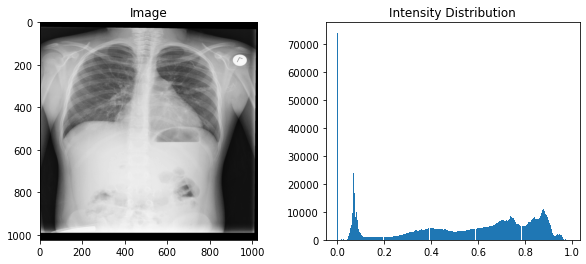

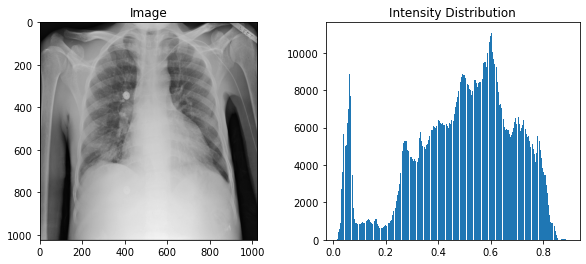

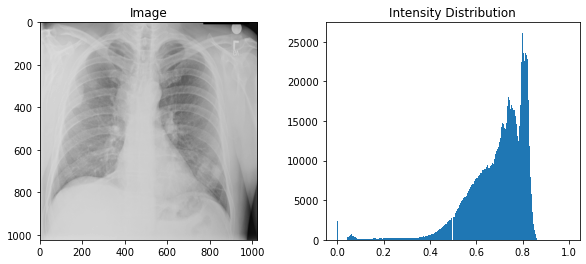

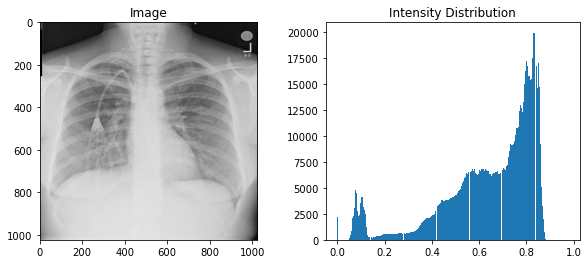

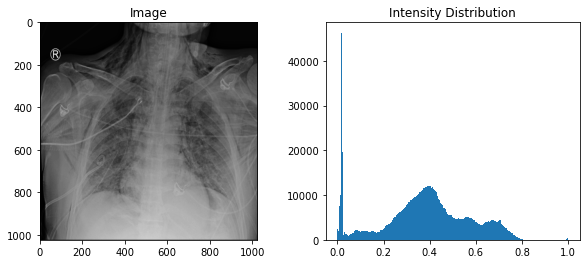

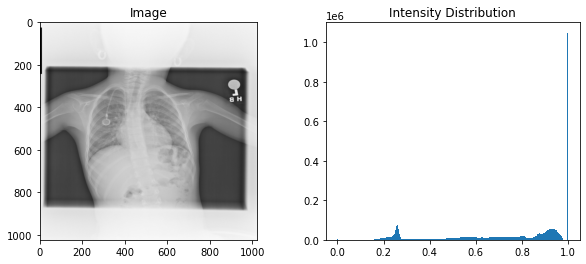

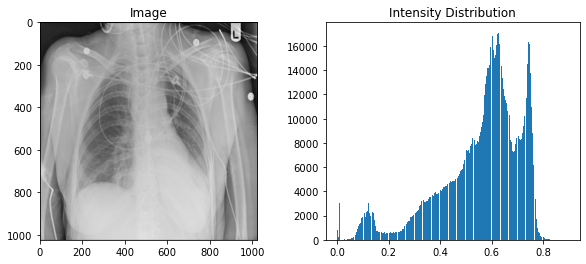

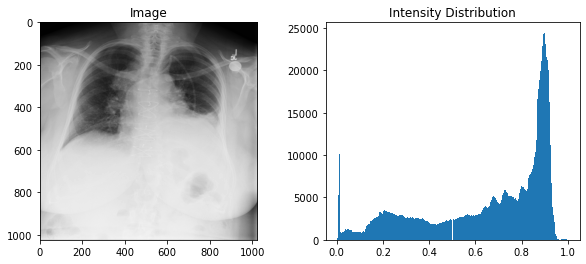

In [88]:
for data in pneumo_data[:10]:
    show_image_distr(data)

In [89]:
def show_image_mask(img_data, th):
    f = plt.figure()
    f.set_figwidth(15)

    s1 = f.add_subplot(1, 5, 1)
    s1.set_title('Image')
    plt.imshow(img_data, cmap='gray')

    s2 = f.add_subplot(1, 5, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(img_data.ravel(), bins = 256)
    
    mask = data > th

    s3 = f.add_subplot(1, 5, 3)
    s3.set_title('Mask')
    plt.imshow(mask.astype(int)*255, cmap='gray')
    
    s4 = f.add_subplot(1, 5, 4)
    s4.set_title('Intens. Distri. & MASK')
    plt.hist(img_data[mask], bins = 256)
    
    #Subtract mean from intensity values bringing 0 to the center and divide by standard deviation
    #this will help the weights of CNN stay under control
    s5 = f.add_subplot(1, 5, 5)
    s5.set_title('Standard. Intens. Distri. & MASK')
    plt.hist(((img_data[mask] - np.mean(img_data[mask]))/np.std(img_data[mask])).ravel(), bins=250)
    
    
    plt.show()

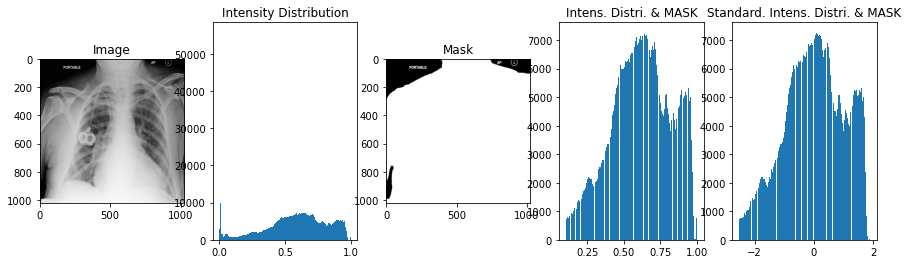

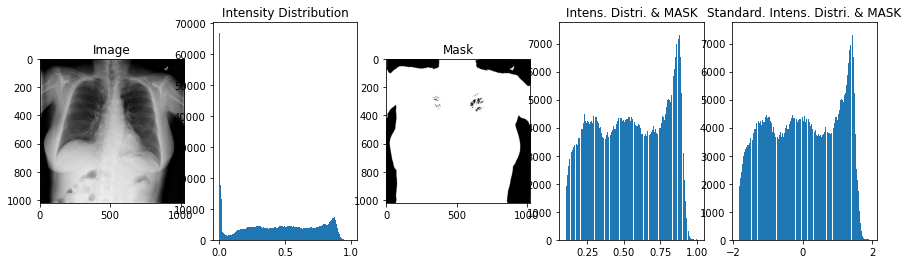

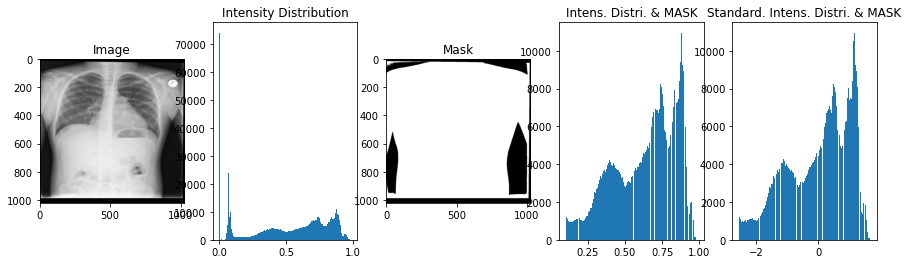

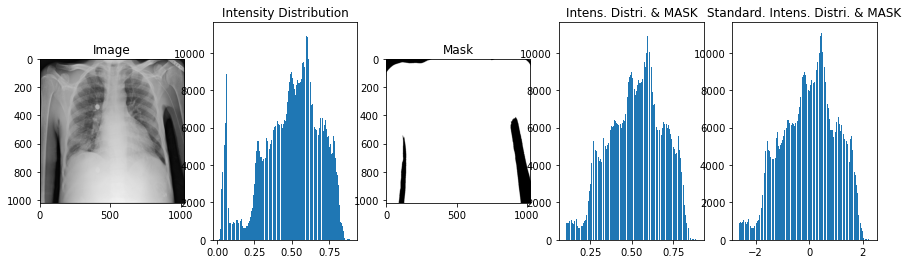

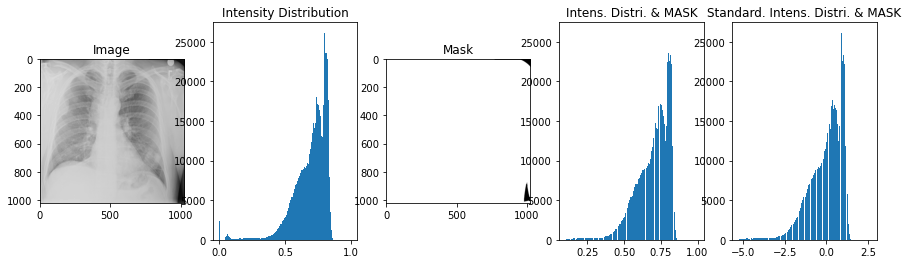

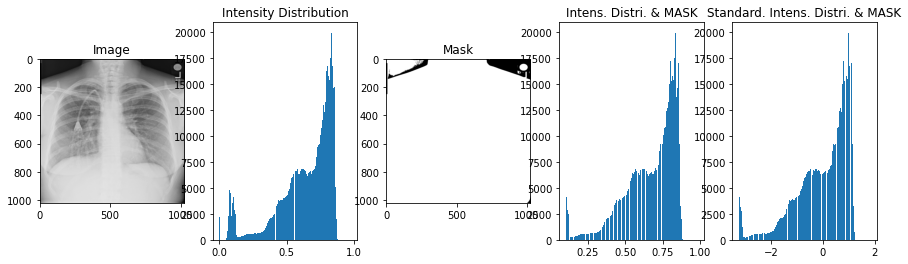

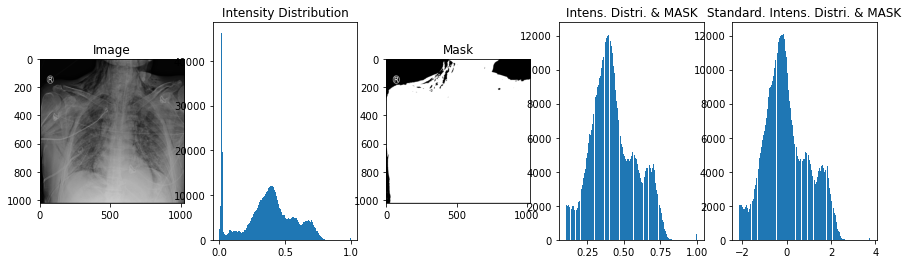

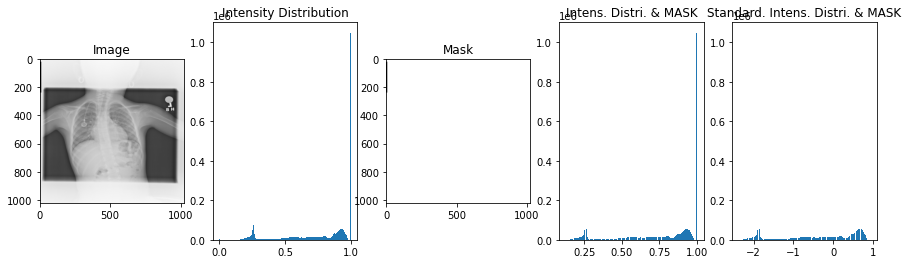

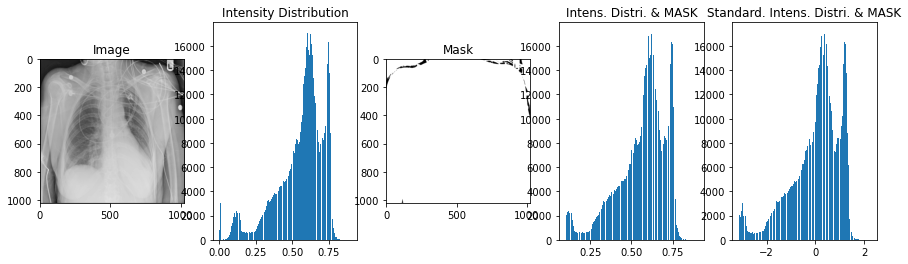

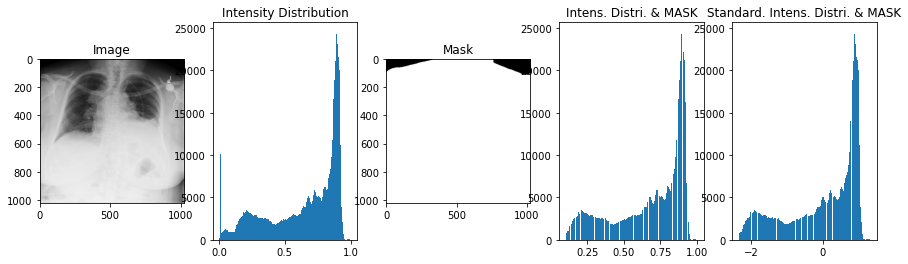

In [90]:
background_threshold = 0.1

for data in pneumo_data[:10]:
    show_image_mask(data, background_threshold)

The initial spike in each image is the background black pixels. The spike is removed once the mask is applied. The distribution is then standardized by subtracting the mean from intensity values and dividing it by standard deviation bringing 0 to the center. This will help the weights of CNN stay under control

Need to remove foreground too (excessively white areas of extenal entities)

In [91]:
foreground_threshold = 0.9

Label: Pneumonia, number of samples for intensity: 62


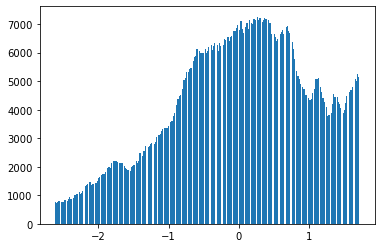

In [92]:
max_samples = 1000
def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        data = image.imread(path)
        mask = (data > background_threshold) & (data < foreground_threshold)
        intensities.extend(((data[mask] - np.mean(data[mask]))/np.std(data[mask])).flatten().tolist())
        return intensities
    
plt.hist(get_intensities('Pneumonia'), bins = 256)
plt.show()



In [93]:
def get_images(label):
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        print(path)
        data = image.imread(path)
        return data

Label: Mass, number of samples for intensity: 284
/data/images_001/images/00000040_003.png
Label: Consolidation, number of samples for intensity: 226
/data/images_001/images/00000040_003.png
Label: Cardiomegaly, number of samples for intensity: 141
/data/images_001/images/00000013_026.png
Label: Nodule, number of samples for intensity: 313
/data/images_001/images/00000061_025.png
Label: Pneumonia, number of samples for intensity: 62
/data/images_002/images/00001373_010.png
Label: Effusion, number of samples for intensity: 644
/data/images_001/images/00000032_001.png
Label: Infiltration, number of samples for intensity: 967
/data/images_001/images/00000013_005.png
Label: Atelectasis, number of samples for intensity: 508
/data/images_001/images/00000030_001.png
Label: Pneumothorax, number of samples for intensity: 271
/data/images_001/images/00000013_005.png
Label: Hernia, number of samples for intensity: 13
/data/images_004/images/00006624_002.png
Label: Edema, number of samples for int

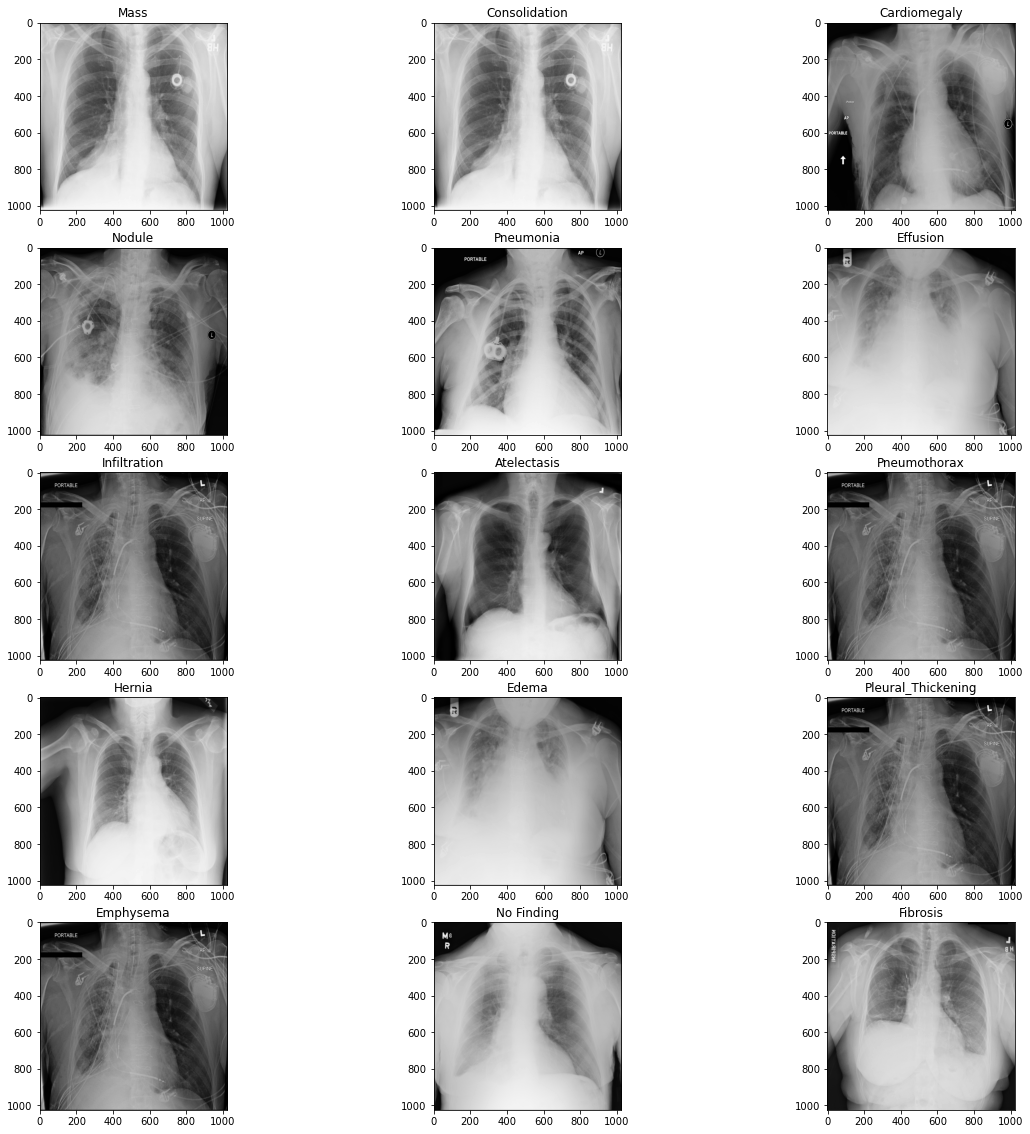

In [94]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

for i,finding in enumerate(findings):
    data = get_images(finding)

    s = f.add_subplot(5, len(findings)/5, i+1)
    s.set_title(finding)
    plt.imshow(data, cmap='gray')
    
plt.show()

In [95]:
max_samples = 1000

def get_intensities(label):
    intensities = []
    paths = sample_df[sample_df[label]==1].head(max_samples)['image_path'].values
    print(f'Label: {label}, number of samples for intensity: {len(paths)}')
    for path in paths:
        print(path)
        data = image.imread(path)
        mask = (data > background_threshold) & (data < foreground_threshold)
        intensities.extend(((data[mask] - np.mean(data[mask]))/np.std(data[mask])).flatten().tolist())
        return intensities

Label: Mass, number of samples for intensity: 284
/data/images_001/images/00000040_003.png
Label: Consolidation, number of samples for intensity: 226
/data/images_001/images/00000040_003.png
Label: Cardiomegaly, number of samples for intensity: 141
/data/images_001/images/00000013_026.png
Label: Nodule, number of samples for intensity: 313
/data/images_001/images/00000061_025.png
Label: Pneumonia, number of samples for intensity: 62
/data/images_002/images/00001373_010.png
Label: Effusion, number of samples for intensity: 644
/data/images_001/images/00000032_001.png
Label: Infiltration, number of samples for intensity: 967
/data/images_001/images/00000013_005.png
Label: Atelectasis, number of samples for intensity: 508
/data/images_001/images/00000030_001.png
Label: Pneumothorax, number of samples for intensity: 271
/data/images_001/images/00000013_005.png
Label: Hernia, number of samples for intensity: 13
/data/images_004/images/00006624_002.png
Label: Edema, number of samples for int

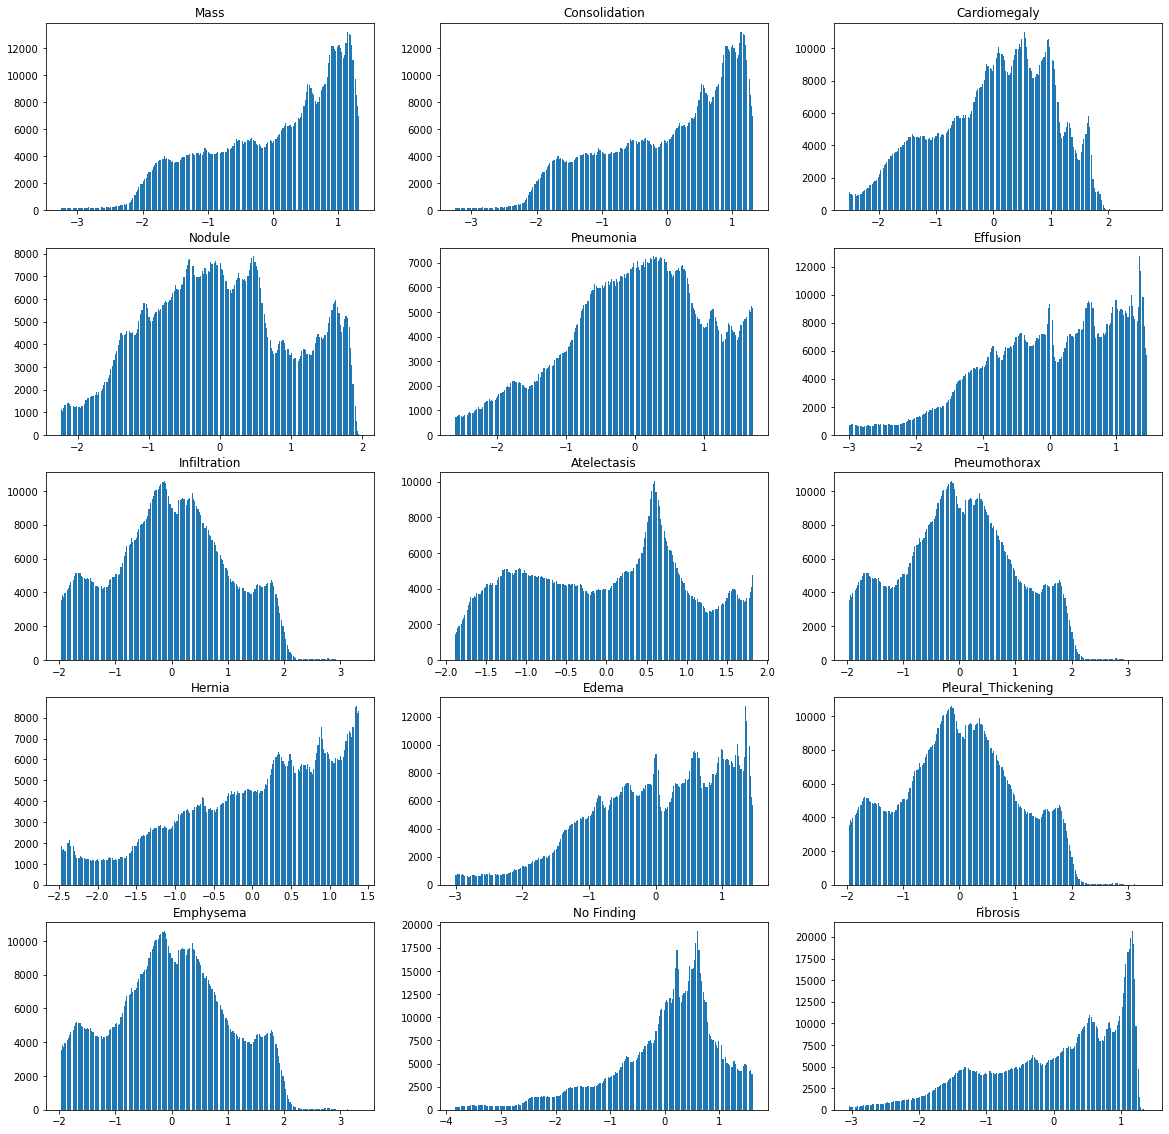

In [96]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

for i,finding in enumerate(findings):
    intensities = get_intensities(finding)

    s = f.add_subplot(5, len(findings)/5, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

Label: Emphysema, number of samples for intensity: 127
/data/images_001/images/00000013_005.png
Label: Pleural_Thickening, number of samples for intensity: 176
/data/images_001/images/00000013_005.png
Label: Pneumothorax, number of samples for intensity: 271
/data/images_001/images/00000013_005.png
Label: Infiltration, number of samples for intensity: 967
/data/images_001/images/00000013_005.png


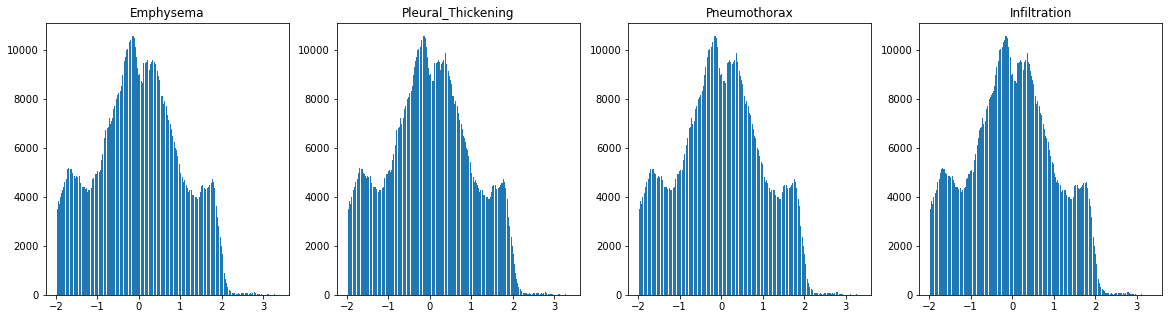

In [97]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Emphysema', 'Pleural_Thickening', 'Pneumothorax', 'Infiltration']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

Label: Consolidation, number of samples for intensity: 226
/data/images_001/images/00000040_003.png
Label: Edema, number of samples for intensity: 118
/data/images_001/images/00000032_001.png
Label: Effusion, number of samples for intensity: 644
/data/images_001/images/00000032_001.png
Label: Hernia, number of samples for intensity: 13
/data/images_004/images/00006624_002.png


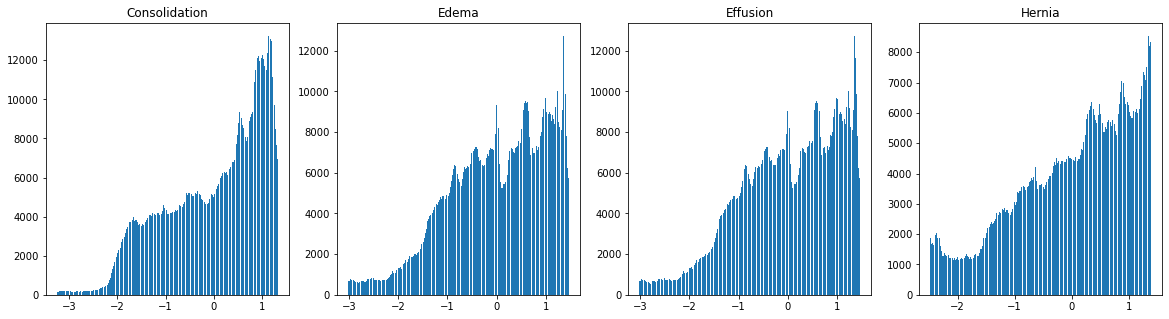

In [98]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Consolidation', 'Edema', 'Effusion', 'Hernia']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 4, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()

Label: Pneumonia, number of samples for intensity: 62
/data/images_002/images/00001373_010.png
Label: Nodule, number of samples for intensity: 313
/data/images_001/images/00000061_025.png
Label: Cardiomegaly, number of samples for intensity: 141
/data/images_001/images/00000013_026.png


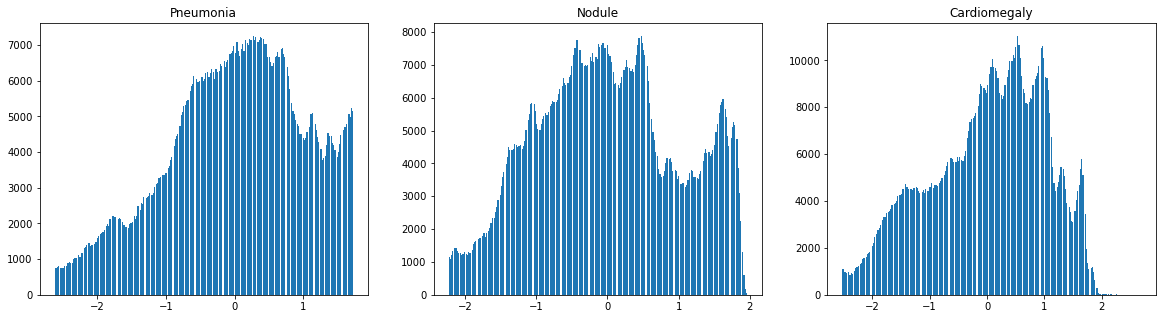

In [99]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)

for i,finding in enumerate([ 'Pneumonia', 'Nodule', 'Cardiomegaly']):
    intensities = get_intensities(finding)

    s = f.add_subplot(1, 3, i+1)
    s.set_title(finding)
    plt.hist(intensities, bins = 256)
    
plt.show()


Summary

Pre-processing:
-    Images in the dataset need to be normalized, in the range from 0.0 to 1.0
-    Background (almost black) needs to be removed, approximate threshold: > 0.1
-    Foreground (almost white) needs to be removed too, approximate thereshold: < 0.9. (These could be external entities, absorbing light very well, possibly pieces of plastic?)
Model Design:
-    'Pneumonia' images intensity distribution is quite similar to those of 'Nodule', and somewhat similar to those of 'Cardiomegaly'.
-    'Consolidation', 'Edema', 'Effusion', 'Hernia' have quite different from Pneumonia, but very similar to one another distributions.
-    Also, 'Emphysema', 'Pleural Thickening', 'Pneumothorax', 'Infitration' form another group that has distribution very similar to one another
-    In addition to the above the key feature here, which is that Pneumonia comorbid with infiltration and Effusion mainly. This is the reason it will be difficult to create a model that distinguish, for instance, when there is only Infiltration (Negative to Pneumonia) or Infiltration+Pneumonia (Positive to Pneumonia).

In [100]:
sample_df.head()

Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  OriginalImagePixelSpacing_x  ...  \
0                3056                 2544                        0.139  ...   
1                2500                 2048                        0.168  ...   
2                2500                 2048                        0.168  ...   
3                2992                 2991                        0.143  ...   
4                2500                 2048                        0.168  ...   

   Infiltration  Atelectasis  Pneumothorax  Hernia  Edema  Pleural_Thickening  \
0           1.0          0.0           1.0     0.0    0.0                 1.0   
1           0.0          0.0           0.0     0.0    0.0                 0.0   
2           0.0          0.0           0.0     0.0    0.0                 0.0   
3           0.0          1.0           0.0     0.0    0.0                 0.0   
4           0.0          0.0           0.0     0.0    1.0                 0.0   

   Emphysema  No Finding  Fibrosis                                image_path  
0        1.0         0.0       0.0  /data/images_001/images/00000013_005.png  
1        1.0         0.0       0.0  /data/images_001/images/00000013_026.png  
2        0.0         1.0       0.0  /data/images_001/images/00000017_001.png  
3        0.0         0.0       0.0  /data/images_001/images/00000030_001.png  
4        0.0         0.0       0.0  /data/images_001/images/00000032_001.png  

[5 rows x 27 columns]